# Ecommerce Customer Segmentation
## About Dataset
This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. Also included, is a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.



### Importing Required Libraries

In [184]:
import os
import re
import us
import glob
import warnings
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from kneed import DataGenerator, KneeLocator
warnings.filterwarnings('ignore')

### Loading the Data files

In [185]:
# Specify the folder path and the regex pattern for file names
folder_path = './data'
file_pattern = '*.csv'  # Adjust the pattern as needed

# Use glob to get a list of file paths that match the pattern
file_paths = glob.glob(f'{folder_path}/{file_pattern}')

# Create an empty list to store DataFrames
dataframes = []

# Loop through the file paths and read each CSV file into a DataFrame
for file_path in file_paths:
    # Extract the file name using regex
    file_name = re.search(r'([^\/]+)\.csv', file_path).group(1)
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Add a column with the file name to identify the source
    # df['source_file'] = file_name
    
    # Append the DataFrame to the list
    dataframes.append(df)

In [186]:
"""
    There are nine (9) csv files in the data path.
    So, there should also be nine (9) dataframes in the list of dataframes. 
"""
assert(len(os.listdir("./data")) == len(dataframes), "Number of CSV files does not match the number of dataframes")

### Unpacking the list of dataframes

In [187]:
# List the files in the order which there were read in with pandas for correct unpacking
os.listdir("./data")

['olist_sellers_dataset.csv',
 'product_category_name_translation.csv',
 'olist_orders_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv']

In [188]:
# Assigning variables to each item in the list of dataframes for distinctiveness
sellers_df, product_category_df, orders_df, order_items_df, customers_df, geolocation_df,\
order_payments_df, order_reviews_df, products_df = dataframes

### Inspecting the DataFrames

In [189]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [190]:
product_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [191]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [192]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [193]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [194]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [195]:
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [196]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [197]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


### Merging all DataFrames into one

In [198]:
"""
    `products_df` and `product_category_df` have the column `product_category_name` in common so they can be merged.
    An inner merge has been used to remove null entries.
"""
products_merged = pd.merge(products_df, product_category_df, on='product_category_name', how='inner')

In [199]:
products_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32328 entries, 0 to 32327
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32328 non-null  object 
 1   product_category_name          32328 non-null  object 
 2   product_name_lenght            32328 non-null  float64
 3   product_description_lenght     32328 non-null  float64
 4   product_photos_qty             32328 non-null  float64
 5   product_weight_g               32327 non-null  float64
 6   product_length_cm              32327 non-null  float64
 7   product_height_cm              32327 non-null  float64
 8   product_width_cm               32327 non-null  float64
 9   product_category_name_english  32328 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.5+ MB


In [200]:
products_merged.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


In [201]:
"""
    Keep only the English names of the product categories.
"""

unrequired_columns = ["product_category_name"]
products_merged.drop(unrequired_columns, axis=1, inplace=True)

# Rename English product categories
products_merged.rename({"product_category_name_english": "product_category"}, axis=1, inplace=True)

In [202]:
products_merged.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


In [203]:
"""
    The other dataframes bear a unique id so they can all be merged into one with `products_merged`.
"""
df = pd.merge(orders_df, customers_df, on='customer_id')
df = df.merge(order_items_df, on='order_id')
df = df.merge(order_payments_df, on='order_id')
df = df.merge(products_merged, on='product_id')
df = df.merge(sellers_df, on='seller_id')

In [204]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115878 entries, 0 to 115877
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115878 non-null  object 
 1   customer_id                    115878 non-null  object 
 2   order_status                   115878 non-null  object 
 3   order_purchase_timestamp       115878 non-null  object 
 4   order_approved_at              115864 non-null  object 
 5   order_delivered_carrier_date   114673 non-null  object 
 6   order_delivered_customer_date  113383 non-null  object 
 7   order_estimated_delivery_date  115878 non-null  object 
 8   customer_unique_id             115878 non-null  object 
 9   customer_zip_code_prefix       115878 non-null  int64  
 10  customer_city                  115878 non-null  object 
 11  customer_state                 115878 non-null  object 
 12  order_item_id                 

### Data Wrangling

In [206]:
"""
    From here on, I'll be retaining only customer demographics, order details, transactional/payment information,
    and product information.
"""

required_columns = ["customer_unique_id", "order_id", "order_status", "order_purchase_timestamp", "customer_zip_code_prefix",
                    "customer_city", "customer_state", "price", "freight_value", "payment_sequential", "payment_type",
                    "payment_installments", "payment_value", "product_category"]
main_df = df[required_columns]

In [207]:
main_df.head()

,customer_unique_id,order_id,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,29.99,8.72,1,credit_card,1,18.12,housewares
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,29.99,8.72,3,voucher,1,2.00,housewares
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,29.99,8.72,2,voucher,1,18.59,housewares
3,3a51803cc0d012c3b5dc8b7528cb05f7,128e10d95713541c87cd1a2e48201934,delivered,2017-08-15 18:29:31,3366,sao paulo,SP,29.99,7.78,1,credit_card,3,37.77,housewares
4,ef0996a1a279c26e7ecbd737be23d235,0e7e841ddf8f8f2de2bad69267ecfbcf,delivered,2017-08-02 18:24:47,2290,sao paulo,SP,29.99,7.78,1,credit_card,1,37.77,housewares


In [208]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115878 entries, 0 to 115877
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_unique_id        115878 non-null  object 
 1   order_id                  115878 non-null  object 
 2   order_status              115878 non-null  object 
 3   order_purchase_timestamp  115878 non-null  object 
 4   customer_zip_code_prefix  115878 non-null  int64  
 5   customer_city             115878 non-null  object 
 6   customer_state            115878 non-null  object 
 7   price                     115878 non-null  float64
 8   freight_value             115878 non-null  float64
 9   payment_sequential        115878 non-null  int64  
 10  payment_type              115878 non-null  object 
 11  payment_installments      115878 non-null  int64  
 12  payment_value             115878 non-null  float64
 13  product_category          115878 non-null  o

In [209]:
# Correcting the data types across the dataframe
main_df["order_purchase_timestamp"] = pd.to_datetime(main_df["order_purchase_timestamp"])

# Converting zipcode prefix from int to string since I won't be aggregating on it.
main_df["customer_zip_code_prefix"] = main_df["customer_zip_code_prefix"].astype(str)

In [210]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115878 entries, 0 to 115877
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_unique_id        115878 non-null  object        
 1   order_id                  115878 non-null  object        
 2   order_status              115878 non-null  object        
 3   order_purchase_timestamp  115878 non-null  datetime64[ns]
 4   customer_zip_code_prefix  115878 non-null  object        
 5   customer_city             115878 non-null  object        
 6   customer_state            115878 non-null  object        
 7   price                     115878 non-null  float64       
 8   freight_value             115878 non-null  float64       
 9   payment_sequential        115878 non-null  int64         
 10  payment_type              115878 non-null  object        
 11  payment_installments      115878 non-null  int64         
 12  pa

### Data Exploration and Feature Engineering

In [241]:
"""
    It would be good to have a sense of the total number of customers being considered,
    number of orders and a ball park figure of the number of orders per customer
"""
customers = main_df["customer_unique_id"].nunique()
orders = main_df["order_id"].nunique()
orders_per_customer = round(orders/customers, 2)

print("Number of customers in the Dataset:", customers)
print("Number of orders in total:", orders)
print("Number of Orders per customer:", orders_per_customer)

Number of customers in the Dataset: 94087
Number of orders in total: 97255
Number of Orders per customer: 1.03


In [211]:
"""
    To examine the number of orders per year and average number of orders per month,
    there is a need to engineer new features from the `order_purchase_timestamp` column.
"""
# Get year from timestamp
main_df['order_purchase_year'] = main_df['order_purchase_timestamp'].dt.year.astype(str)

# Get month from timestamp
main_df['order_purchase_month'] = main_df['order_purchase_timestamp'].dt.month.astype(str)

# Get day from timestamp
main_df['order_purchase_day'] = main_df['order_purchase_timestamp'].dt.day.astype(str)

In [212]:
main_df.head()

,customer_unique_id,order_id,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category,order_purchase_year,order_purchase_month,order_purchase_day
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,29.99,8.72,1,credit_card,1,18.12,housewares,2017,10,2
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,29.99,8.72,3,voucher,1,2.00,housewares,2017,10,2
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,29.99,8.72,2,voucher,1,18.59,housewares,2017,10,2
3,3a51803cc0d012c3b5dc8b7528cb05f7,128e10d95713541c87cd1a2e48201934,delivered,2017-08-15 18:29:31,3366,sao paulo,SP,29.99,7.78,1,credit_card,3,37.77,housewares,2017,8,15
4,ef0996a1a279c26e7ecbd737be23d235,0e7e841ddf8f8f2de2bad69267ecfbcf,delivered,2017-08-02 18:24:47,2290,sao paulo,SP,29.99,7.78,1,credit_card,1,37.77,housewares,2017,8,2


In [213]:
# Compute number of orders per year
annual_orders = main_df.groupby("order_purchase_year").size().reset_index(name='num_orders')
annual_orders

,order_purchase_year,num_orders
0,2016,383
1,2017,52557
2,2018,62938


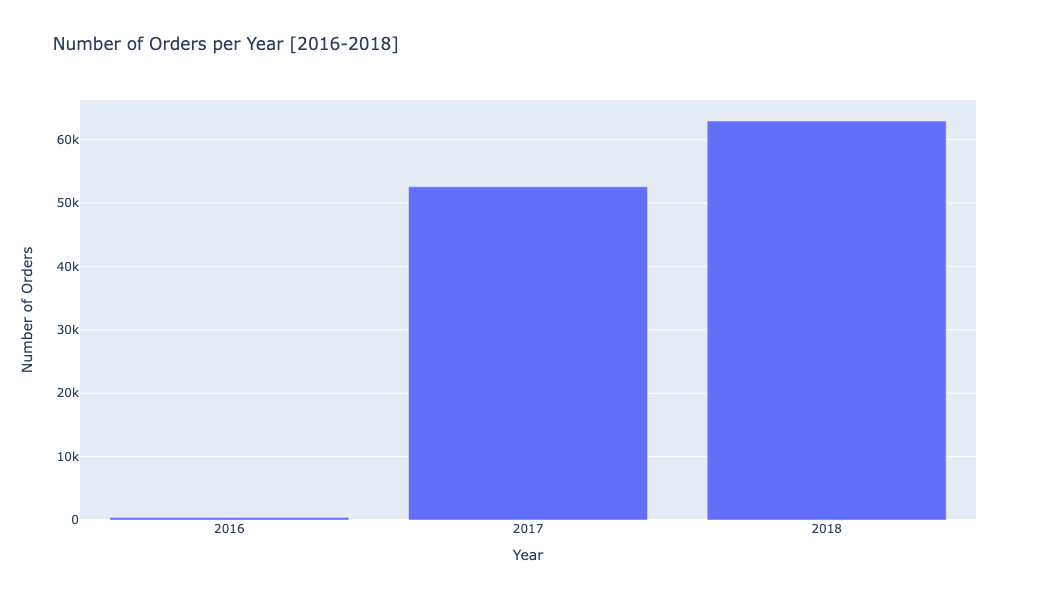

In [214]:
# Plot the Number of orders per year from 2016 to 2018
annual_orders_fig = px.bar(
    data_frame=annual_orders,
    x="order_purchase_year",
    y="num_orders",
    title="Number of Orders per Year [2016-2018]")
annual_orders_fig.update_layout(xaxis_title="Year", yaxis_title="Number of Orders", height=600)
annual_orders_fig.show()

In [215]:
# Compute the average number of orders per month for each year available
# Group by both 'order_year' and 'order_month' and count the number of orders in each month
monthly_orders = main_df.groupby(['order_purchase_year', 'order_purchase_month']).size().reset_index(name='num_orders')

# Group by 'order_year' and calculate the average number of orders per month to two decimal places
average_monthly_orders = monthly_orders.groupby('order_purchase_year')['num_orders'].mean().reset_index(name='average_monthly_orders').round(2)
average_monthly_orders

,order_purchase_year,average_monthly_orders
0,2016,127.67
1,2017,4379.75
2,2018,6993.11


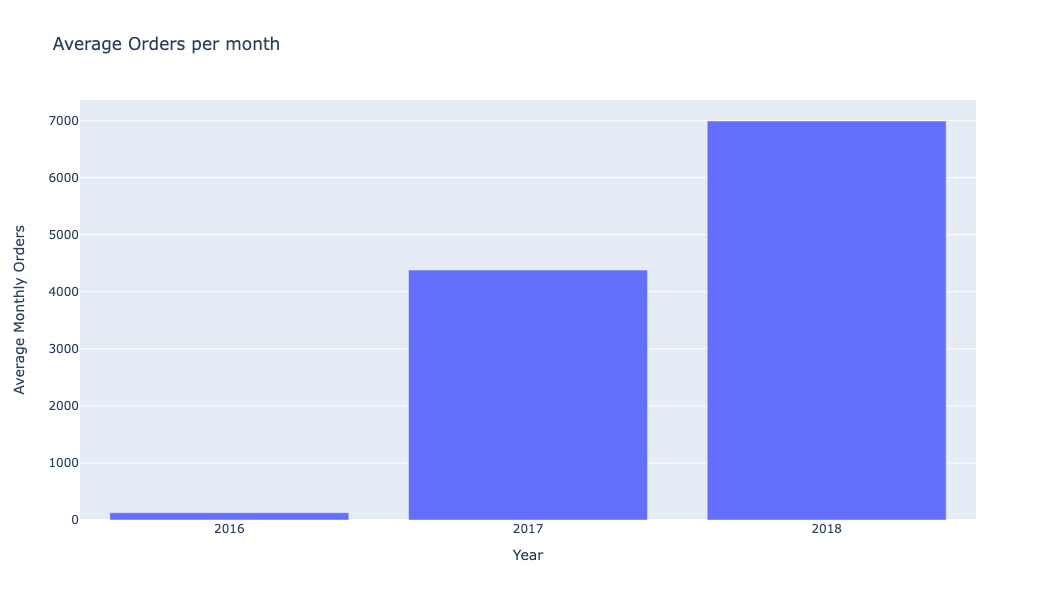

In [216]:
# Plot the average number of orders per month
monthly_orders_fig = px.bar(
    data_frame=average_monthly_orders,
    x="order_purchase_year",
    y="average_monthly_orders",
    title="Average Orders per month")
monthly_orders_fig.update_layout(xaxis_title="Year", yaxis_title="Average Monthly Orders", height=600)
monthly_orders_fig.show()

In [224]:
# Compute customer distribution by state
customers_per_state = main_df.groupby("customer_state").size().reset_index(name='num_customers').sort_values("num_customers", ascending=False)
customers_per_state.head()

,customer_state,num_customers
25,SP,48838
18,RJ,15089
10,MG,13451
22,RS,6384
17,PR,5882


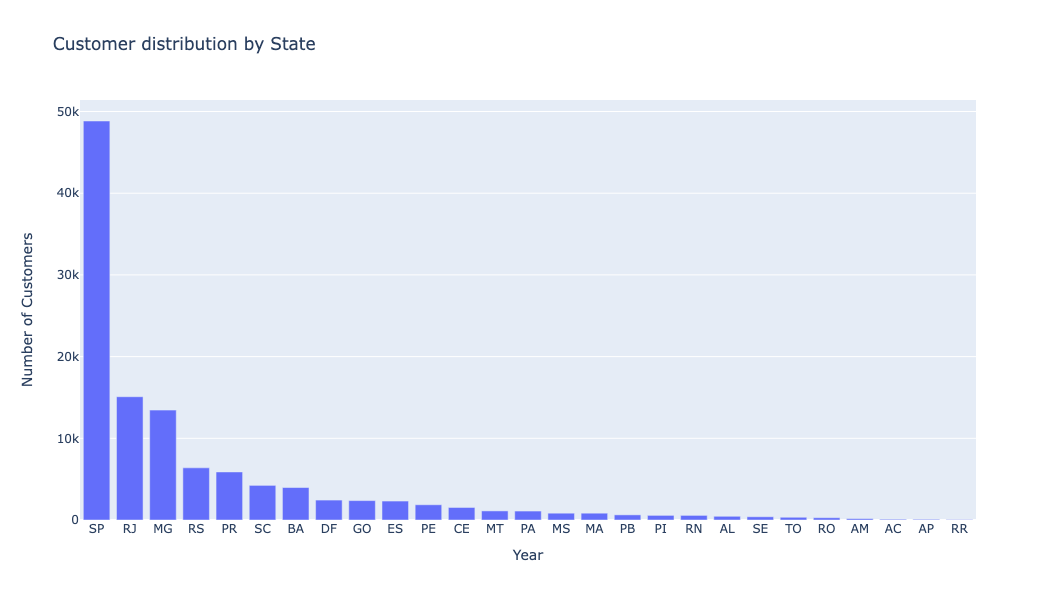

In [225]:
# Plot the customer distrbution by state
customers_fig = px.bar(
    data_frame=customers_per_state,
    x="customer_state",
    y="num_customers",
    title="Customer distribution by State")
customers_fig.update_layout(xaxis_title="Year", yaxis_title="Number of Customers", height=600)
customers_fig.show()

In [229]:
# Compute the most sought after product categories
product_count = main_df.groupby("product_category").size().reset_index(name="num_purchases").sort_values("num_purchases", ascending=False)

# I'll be taking only the top 10 categories
product_count[:10]

,product_category,num_purchases
7,bed_bath_table,11823
43,health_beauty,9972
65,sports_leisure,8945
39,furniture_decor,8744
15,computers_accessories,8082
49,housewares,7355
70,watches_gifts,6201
68,telephony,4721
42,garden_tools,4574
5,auto,4379


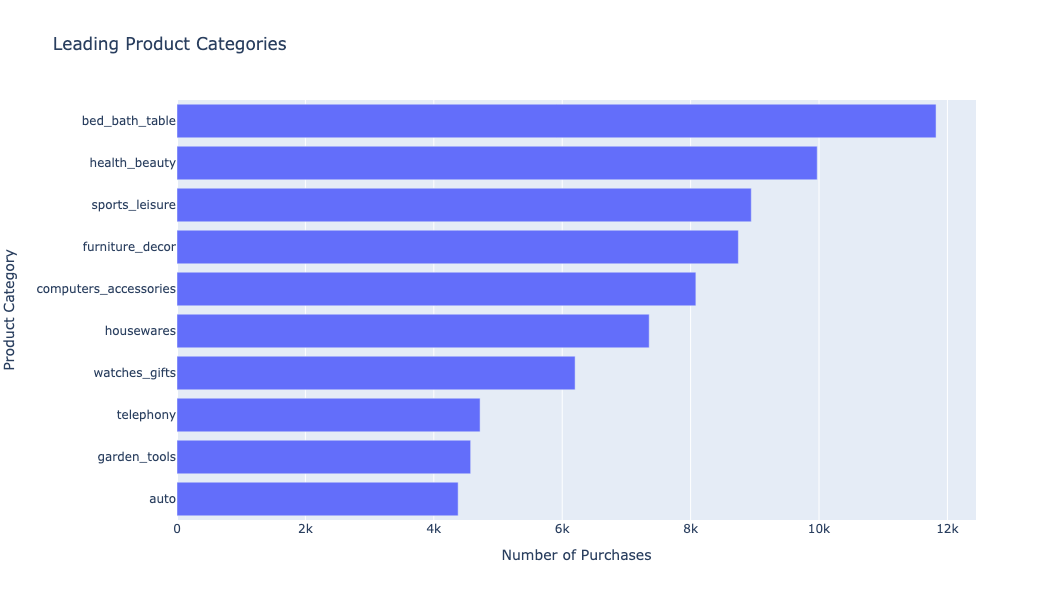

In [232]:
# Plot distribution for the top 10 product categories
product_fig = px.bar(
    data_frame=product_count[:10].sort_values("num_purchases", ascending=True),
    x="num_purchases",
    y="product_category",
    title="Leading Product Categories")
product_fig.update_layout(xaxis_title="Number of Purchases", yaxis_title="Product Category", height=600)
product_fig.show()

In [242]:
# Check for cardinality
main_df.nunique()

customer_unique_id          94087
order_id                    97255
order_status                    7
order_purchase_timestamp    96720
customer_zip_code_prefix    14927
customer_city                4095
customer_state                 27
price                        5899
freight_value                6977
payment_sequential             29
payment_type                    4
payment_installments           24
payment_value               28765
product_category               71
order_purchase_year             3
order_purchase_month           12
order_purchase_day             31
dtype: int64

In [243]:
"""
   `customer_unique_id` and `order_id` are the only high cardinality columns whose presence holds no significance.
   Therefore, it will be dropped.
"""
main_df.drop(["customer_unique_id", "order_id"], axis=1, inplace=True)

In [244]:
main_df.head()

,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category,order_purchase_year,order_purchase_month,order_purchase_day
0,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,29.99,8.72,1,credit_card,1,18.12,housewares,2017,10,2
1,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,29.99,8.72,3,voucher,1,2.00,housewares,2017,10,2
2,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,29.99,8.72,2,voucher,1,18.59,housewares,2017,10,2
3,delivered,2017-08-15 18:29:31,3366,sao paulo,SP,29.99,7.78,1,credit_card,3,37.77,housewares,2017,8,15
4,delivered,2017-08-02 18:24:47,2290,sao paulo,SP,29.99,7.78,1,credit_card,1,37.77,housewares,2017,8,2


### Selecting High Variance features which are best for clustering

In [251]:
# Calculate variance, get 10 largest features
top_ten_var = main_df.select_dtypes("number").var().sort_values(ascending=True)
top_ten_var

payment_sequential          0.526079
payment_installments        7.728278
freight_value             251.885460
price                   33935.956032
payment_value           71883.507173
dtype: float64

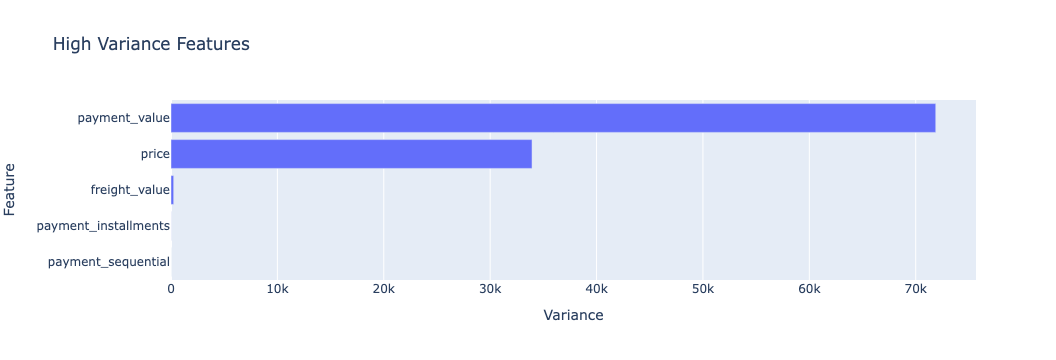

In [252]:
# Create horizontal bar chart of `top_ten_var`
var_fig = px.bar(x=top_ten_var,
            y=top_ten_var.index,
            title="High Variance Features")
var_fig.update_layout(xaxis_title="Variance", yaxis_title="Feature")
var_fig.show()

In [254]:
# Calculate trimmed variance
top_ten_trim_var = main_df.select_dtypes("number").apply(trimmed_var).sort_values()
top_ten_trim_var

payment_sequential         0.000000
payment_installments       3.199876
freight_value             24.770744
price                   2522.407743
payment_value           5073.174298
dtype: float64

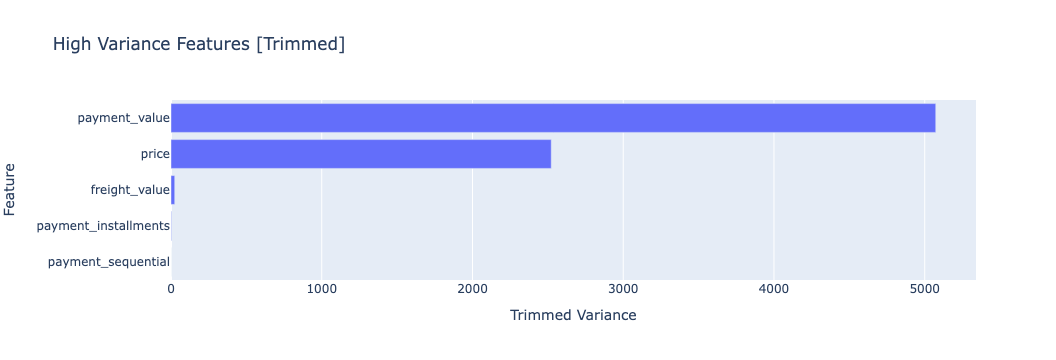

In [255]:
# Create horizontal bar chart of `top_ten_trim_var`
tim_var_fig = px.bar(x=top_ten_trim_var,
            y=top_ten_trim_var.index,
            title="High Variance Features [Trimmed]")
tim_var_fig.update_layout(xaxis_title="Trimmed Variance", yaxis_title="Feature")

tim_var_fig.show()

In [256]:
#Generate a list high_var_cols with the column names of the five features with the highest trimmed variance
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['payment_sequential',
 'payment_installments',
 'freight_value',
 'price',
 'payment_value']

In [257]:
# Create the feature matrix X. It should contain the five columns in high_var_cols
X = df[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (115878, 5)


,payment_sequential,payment_installments,freight_value,price,payment_value
0,1,1,8.72,29.99,18.12
1,3,1,8.72,29.99,2.00
2,2,1,8.72,29.99,18.59
3,1,3,7.78,29.99,37.77
4,1,1,7.78,29.99,37.77


In [258]:
# Create a DataFrame X_summary with the mean and standard deviation for all the features in X
X_summary = X.aggregate(["mean","std"]).astype(int)
X_summary

,payment_sequential,payment_installments,freight_value,price,payment_value
mean,1,2,20,120,173
std,0,2,15,184,268


In [ ]:
n_clusters = range(2,15)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # Build model
    model = make_pipeline(StandardScaler(),
                          KMeans(n_clusters=k,random_state=42))
    # Train model
    model.fit(X)
    # Calculate the inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculate silhouette scores
    silhouette_scores.append(silhouette_score(X,model.named_steps["kmeans"].labels_))

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])